# Project Navigation Guidelines

In [2]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)
'''
None

# Trial Description

In [1]:
exp = 3  #experiment number
trial = '1A' #trial number
'''
Trial 1 : 
Algorithms use Vote mechanic.
Resampling done within time period of 2s.
Tested against validation set.
'''
None

# Core Libraries

In [2]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Exploratory Data Analysis

# Prepare/Load Relevant Dataset

In [3]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E'+str(exp)+'_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
50620  19/3/20   15:48:23   0x0006   177    19,13
50621  19/3/20   15:48:24   0x0008   180    19,13
50622  19/3/20   15:48:24   0x0005   177    19,13
50623  19/3/20   15:48:24   0x0009   180    19,13
50624  19/3/20   15:48:24   0x0003   180    19,13

[50625 rows x 5 columns]


In [4]:
# Resample/Reshape Dataset

In [5]:
# Preparation for Date/Time Differences
# ----------------------------------------
fileNameRS = 'E'+str(exp)+'_resampled_'+'T'+str(trial)+'.csv' #resampled file name
# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv(fileNameRS)
    print("File "+fileNameRS +" has been written.")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
50624
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
50620    0.0
50621    0.0
50622    0.0
50623    0.0
50624    0.0
Name: DatetimeSec, Length: 50625, dtype: float64
File E3_resampled_T1A.csv has been written.


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [7]:
resampledDS = pd.read_csv('E'+str(exp)+'_resampled_T'+str(trial)+'.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
k_value_cubeN = math.ceil(len(X_train)**(1/3))
print("k_value_rootN: ", k_value_rootN)
print("k_value_cubeN: ", k_value_cubeN)
print("X_test: ", X_test)
print("y_test: ", y_test)

k_value_rootN:  62
k_value_cubeN:  16
X_test:  [[177. 189. 183. ...   0. 181. 178.]
 [  0. 177. 177. ... 184.   0. 184.]
 [  0.   0. 177. ... 194. 193. 191.]
 ...
 [  0. 177.   0. ...   0. 186. 190.]
 [  0. 177. 177. ... 182. 188. 180.]
 [  0.   0. 177. ... 177. 189.   0.]]
y_test:  [['7,7']
 ['13,1']
 ['19,1']
 ...
 ['13,13']
 ['13,7']
 ['19,13']]


# Load & Resample Test Set (ValidationSet)

In [36]:
# Preparation for Date/Time Differences
# ----------------------------------------
# Read csv file into dataframe.
csvfile = pd.read_csv('E9T2_ValSetUnknown_270320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)
# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E3_valResample_T1A.csv')
    print("FILE WRITTEN")

pivoted_readings.tail()

          Date       Time      ID2  RSSI Location
0      27/3/20   11:58:12   0x0006   187     10,4
1      27/3/20   11:58:12   0x0002   187     10,4
2      27/3/20   11:58:12   0x0001   182     10,4
3      27/3/20   11:58:12   0x0007   177     10,4
4      27/3/20   11:58:12   0x0004   183     10,4
...        ...        ...      ...   ...      ...
13324  27/3/20   13:58:47   0x0006   184     3,18
13325  27/3/20   13:58:47   0x0004   177     3,18
13326  27/3/20   13:58:47   0x0009   177     3,18
13327  27/3/20   13:58:47   0x0007   183     3,18
13328  27/3/20   13:58:47   0x000C   190     3,18

[13329 rows x 5 columns]
2020-03-27
0:00:00
13328
    DatetimeSec      ID2  RSSI Location
0       43092.0   0x0006   187     10,4
1       43092.0   0x0002   187     10,4
2       43092.0   0x0001   182     10,4
3       43092.0   0x0007   177     10,4
4       43092.0   0x0004   183     10,4
5       43092.0   0x000B   177     10,4
6       43093.0   0x0008   179     10,4
7       43093.0   0x000C   17

,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
1350.0,"3,18",0.0,177.0,0.0,0.0,177.0,177.0,185.0,183.0,179.0,190.0,191.0,180.0
1351.0,"3,18",0.0,177.0,0.0,0.0,177.0,177.0,185.0,183.0,179.0,190.5,191.0,179.0
1352.0,"3,18",0.0,177.0,0.0,0.0,0.0,0.0,186.0,190.0,180.0,190.0,192.0,180.0
1353.0,"3,18",0.0,0.0,177.0,177.0,185.0,185.0,181.0,0.0,177.0,179.0,193.0,189.0
1354.0,"3,18",0.0,0.0,177.0,177.0,184.0,184.0,183.0,189.0,177.0,180.0,193.0,190.0


In [37]:
resampledDS = pd.read_csv('E3_valResample_T1A.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_test = ips_data.to_numpy()
y_test = ips_label.to_numpy()
print(len(y_test))
y_test

1353


array([['10,4'],
       ['10,4'],
       ['10,4'],
       ...,
       ['3,18'],
       ['3,18'],
       ['3,18']], dtype=object)

# KNN Algorithm

In [10]:
n_samples = 20

#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

In [11]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [12]:
# TEST OUTPUT

outArray = []
for i in range(n_samples):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[182.0, 187.0, 194.0, 183.0, 0.0, 187.0, 177.0...","[4,10]","[([178.0, 183.0, 192.0, 177.0, 0.0, 181.0, 177..."
1,1,"[177.0, 186.0, 194.0, 0.0, 185.0, 184.0, 0.0, ...","[4,10]","[([177.0, 192.0, 188.0, 0.0, 191.0, 194.0, 0.0..."
2,2,"[180.0, 182.0, 193.0, 178.0, 181.0, 177.0, 0.0...","[4,10]","[([184.0, 193.0, 192.0, 177.0, 182.0, 188.0, 0..."
3,3,"[179.0, 185.0, 191.0, 0.0, 185.0, 189.0, 177.0...","[4,10]","[([182.0, 191.0, 189.0, 0.0, 192.0, 188.0, 177..."
4,4,"[177.0, 178.0, 191.0, 177.0, 0.0, 188.0, 177.0...","[4,10]","[([177.0, 193.0, 192.0, 177.0, 0.0, 187.0, 178..."


In [13]:
from collections import Counter

#Function enables voting mechanic in KNN for Classification according to majority class vote
def vote(neighbors):
    class_counter = Counter() #A Counter is a dict subclass for counting hashable objects. 
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #neighbor[2] -> label for neighbor(s)
    return class_counter.most_common(1)[0][0]

In [38]:
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    print("index: ", i, 
          ", result of vote: ", vote(neighbors), 
          ", label: ", y_train[i], 
          ", data: ", X_train[i])

index:  0 , result of vote:  7,7 , label:  1,7 , data:  [177. 195. 191. 177. 185. 190. 177. 178.   0. 177. 185. 188.]
index:  1 , result of vote:  7,13 , label:  1,7 , data:  [  0. 193. 193. 177.   0. 190.   0. 180.   0. 177. 184. 187.]
index:  2 , result of vote:  7,13 , label:  13,7 , data:  [  0.   0. 177. 177. 183. 181. 187. 191. 188.   0. 190. 182.]
index:  3 , result of vote:  7,13 , label:  1,13 , data:  [181. 181. 192.   0. 177. 178. 177.   0.   0.   0. 177. 177.]
index:  4 , result of vote:  1,7 , label:  19,1 , data:  [  0.   0.   0. 183.   0. 177. 190. 183. 183. 196. 185. 189.]


In [39]:
#Function returns vote 'probability' - i.e. distribution/percentage majority vote
def vote_prob(neighbors):
    class_counter = Counter() # Counter object - https://docs.python.org/2/library/collections.html
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #add to count of target (class)
        
    # aggregates into tuples ~ zip(*iterables), 
    # Return a list of the n most common elements and their counts from the most common to the least.    
    labels, votes = zip(*class_counter.most_common()) #returns list of sorted most common [labels], [votes]
    #print("L|V: ", labels, votes)
    #print("Class Counter: ", class_counter.most_common)
    winner = class_counter.most_common(1)[0][0]       #majority label
    votes4winner = class_counter.most_common(1)[0][1] #majority vote count
    return winner, votes4winner/sum(votes)            #returns majority label, majority proportion

In [44]:
k_value_knn = 1
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'vote_result', 'vote_prob', 'label', 'prediction'])

indexArray = []
dataArray = []
voteArray = []
probArray = []
labelArray = []
predArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    indexArray.append(i)
    dataArray.append(X_test[i])
    voteRes = vote(neighbors)
    voteArray.append(voteRes)
    probArray.append(voteRes)
    labelArray.append(y_test[i][0])
    predArray.append("CORRECT" if (voteRes == y_test[i]) else "WRONG")
#     print("index: ", i, 
#           ", result of vote: ", vote(neighbors), 
#           ", vote_prob: ", vote_prob(neighbors), 
#           ", label: ", y_test[i], "prediction: "
#         "CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG"
#           ", data: ", X_test[i])

resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['vote_result'] = voteArray
resultsKNN['vote_prob'] = probArray
resultsKNN['label'] = labelArray 
resultsKNN['prediction'] = predArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E3_KNN_T1A_k1.csv has been written.


,index,data,vote_result,vote_prob,label,prediction
0,0,"[182.0, 187.0, 194.0, 183.0, 0.0, 187.0, 177.0...","1,13","1,13","10,4",WRONG
1,1,"[177.0, 186.0, 194.0, 0.0, 185.0, 184.0, 0.0, ...","7,13","7,13","10,4",WRONG
2,2,"[180.0, 182.0, 193.0, 178.0, 181.0, 177.0, 0.0...","1,7","1,7","10,4",WRONG
3,3,"[179.0, 185.0, 191.0, 0.0, 185.0, 189.0, 177.0...","7,7","7,7","10,4",WRONG
4,4,"[177.0, 178.0, 191.0, 177.0, 0.0, 188.0, 177.0...","1,7","1,7","10,4",WRONG
5,5,"[177.0, 180.0, 191.0, 177.0, 185.0, 188.0, 177...","1,7","1,7","10,4",WRONG
6,6,"[177.0, 181.0, 193.0, 177.0, 181.0, 188.0, 177...","7,13","7,13","10,4",WRONG
7,7,"[183.0, 185.0, 193.0, 181.0, 0.0, 193.0, 178.0...","7,13","7,13","10,4",WRONG
8,8,"[184.0, 185.0, 193.0, 181.0, 181.0, 193.0, 178...","7,13","7,13","10,4",WRONG
9,9,"[184.0, 185.0, 0.0, 180.0, 181.0, 193.0, 178.0...","7,13","7,13","10,4",WRONG


# Rank (Harmonic) Weighted KNN

In [21]:
#Function for weighted KNN voting mechanic; harmonic weights based on ranking of datapoint (vote += 1/rank)
def vote_harmonic_weights(neighbors, all_results=True):
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
#         print("Index: ", index)
        class_counter[neighbors[index][2]]
#         print("Location: ", neighbors[index][2])
        class_counter[neighbors[index][2]] += ( 1/(index+1) ) #add (1/ neighbour_rank) for each vote, index+1 = neighbour_rank
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        for key in class_counter:
             class_counter[key] /= total #returns vote proportion for key ("class") in class_counter
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [46]:
k_value_rwknn = 1
writeRWKNN = True
fileNameRWKNN = 'E'+str(exp)+'_RWKNN_'+'T'+str(trial)+'_k'+str(k_value_rwknn)+'.csv'
resultsRWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rwknn, 
                              distance=euclideanDistance)
    voteResult = (vote_harmonic_weights(neighbors,all_results=True))

    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteResult)
    predArray.append("CORRECT" if (voteResult[0] == y_test[i]) else "WRONG")
    
resultsRWKNN['index'] = indexArray
resultsRWKNN['data'] = dataArray
resultsRWKNN['label'] = labelArray
resultsRWKNN['vote_result'] = voteArray
resultsRWKNN['prediction'] = predArray

if (writeRWKNN == True):
    resultsRWKNN.to_csv(fileNameRWKNN, index=False)
    print("File "+fileNameRWKNN+" has been written.")
resultsRWKNN


File E3_RWKNN_T1A_k1.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[182.0, 187.0, 194.0, 183.0, 0.0, 187.0, 177.0...","[10,4]","(1,13, [(1,13, 1.0)])",WRONG
1,1,"[177.0, 186.0, 194.0, 0.0, 185.0, 184.0, 0.0, ...","[10,4]","(7,13, [(7,13, 1.0)])",WRONG
2,2,"[180.0, 182.0, 193.0, 178.0, 181.0, 177.0, 0.0...","[10,4]","(1,7, [(1,7, 1.0)])",WRONG
3,3,"[179.0, 185.0, 191.0, 0.0, 185.0, 189.0, 177.0...","[10,4]","(7,7, [(7,7, 1.0)])",WRONG
4,4,"[177.0, 178.0, 191.0, 177.0, 0.0, 188.0, 177.0...","[10,4]","(1,7, [(1,7, 1.0)])",WRONG
...,...,...,...,...,...
1348,1348,"[0.0, 177.0, 0.0, 0.0, 177.0, 177.0, 185.0, 18...","[3,18]","(19,1, [(19,1, 1.0)])",WRONG
1349,1349,"[0.0, 177.0, 0.0, 0.0, 177.0, 177.0, 185.0, 18...","[3,18]","(19,1, [(19,1, 1.0)])",WRONG
1350,1350,"[0.0, 177.0, 0.0, 0.0, 0.0, 0.0, 186.0, 190.0,...","[3,18]","(13,1, [(13,1, 1.0)])",WRONG
1351,1351,"[0.0, 0.0, 177.0, 177.0, 185.0, 185.0, 181.0, ...","[3,18]","(19,7, [(19,7, 1.0)])",WRONG


# Distance Weighted KNN

In [24]:
#Function for distance weighted KNN voting mechanic; weight based on euclidean distance (vote += 1/distance)
def vote_distance_weights(neighbors, all_results=True):
    debug = False
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        if (debug == True):
            print("Neighbour record: Label is ", label, "with distance ", dist)
            print("Existing count for ", label, "is ", class_counter[label[0]])
            print("Adding count by ", (1 / (dist + 0.01)) )
        class_counter[label] += (1 / (dist + 0.01)) #sensitivity of distance weight can be adjusted here.
        
        
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if (debug == True):
        print("COUNTER: ", class_counter)
        print("----------------------------------------------------")
        print("winner: ", winner)
        print("votes: ", votes4winner)
    
    if all_results:
        total = sum(class_counter.values(), 0.0)
        
        for key in class_counter:
            class_counter[key] /= total
        if (debug == True):
            print("total votes: ", total)
            print("AFTER NORMALISING: ", class_counter)
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [25]:
k_value_dwknn = k_value_rootN
testRange = 200
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    res = vote_distance_weights(neighbors, all_results=True)
    print("index: ", i, 
      ", result of vote: ", res,
    ",label: ", y_test[i], 
    ",prediction: ",
    "CORRECT" if ( res[0] == y_test[i]) else "WRONG")
    print("\n\n")

index:  0 , result of vote:  ('1,13', [('1,13', 0.33269646067335457), ('1,1', 0.20966263439696883), ('7,7', 0.18575556745698205), ('1,7', 0.12864147285215935), ('7,1', 0.12814027459417224), ('7,13', 0.010094588667375276), ('13,7', 0.005009001358987522)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  1 , result of vote:  ('7,13', [('7,13', 0.690729046814122), ('13,13', 0.08974476042707463), ('1,7', 0.07013145769497879), ('1,13', 0.050084344695661094), ('19,13', 0.039903672793453075), ('7,7', 0.03967246794152589), ('1,1', 0.009876454497233822), ('7,1', 0.00985779513595056)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  2 , result of vote:  ('7,13', [('7,13', 0.6234798009117082), ('13,13', 0.11285957906145086), ('1,7', 0.10455175182329957), ('7,7', 0.09009524714795779), ('1,1', 0.06901362105558358)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  3 , result of vote:  ('1,7', [('1,7', 0.272743065058887), ('7,7', 0.2629616654479894), ('7,1', 0.25351064000387274), ('7,13', 0.1089896

index:  31 , result of vote:  ('7,13', [('7,13', 0.2936133713470268), ('1,7', 0.28261365013327155), ('7,7', 0.15972606924360716), ('7,1', 0.1399718102951584), ('13,13', 0.06886140611487448), ('1,1', 0.027165033762396283), ('13,7', 0.023567911566367363), ('1,13', 0.0044807475372977525)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  32 , result of vote:  ('1,7', [('1,7', 0.45980885974856606), ('7,13', 0.40986556340537644), ('7,7', 0.1155185144763611), ('13,13', 0.01480706236969654)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  33 , result of vote:  ('7,1', [('7,1', 0.27187843716876575), ('19,7', 0.18931192083216375), ('7,13', 0.16488178350907454), ('1,7', 0.1393737463561093), ('7,7', 0.08973053133105427), ('13,1', 0.08629473363073767), ('13,13', 0.02761203939622463), ('13,7', 0.02303566183234376), ('19,13', 0.007881145943526185)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  34 , result of vote:  ('7,13', [('7,13', 0.28970450204609044), ('7,7', 0.2886235560681694), ('1,7', 0

index:  62 , result of vote:  ('1,1', [('1,1', 0.2320784725995661), ('7,7', 0.1560823173899459), ('7,1', 0.14983669653478196), ('7,13', 0.14136224907115547), ('1,13', 0.13022603761827478), ('1,7', 0.11678048630334253), ('19,7', 0.04583569984980667), ('13,7', 0.027798040633126613)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  63 , result of vote:  ('7,13', [('7,13', 0.553099046217073), ('7,7', 0.22477245193617912), ('1,7', 0.1685472391024006), ('13,13', 0.05358126274434731)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  64 , result of vote:  ('7,7', [('7,7', 0.4329982985502875), ('7,13', 0.35226165139040105), ('7,1', 0.06681140303544553), ('19,7', 0.03890022296190607), ('13,13', 0.03824157994682281), ('1,13', 0.03567299818859325), ('1,7', 0.03163791944555279), ('1,1', 0.0034759264809909097)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  65 , result of vote:  ('7,13', [('7,13', 0.5519018012202849), ('1,7', 0.27557062927944054), ('7,7', 0.1042470568571296), ('13,13', 0.068280

index:  93 , result of vote:  ('7,7', [('7,7', 0.45998765919280593), ('7,13', 0.24519774841977315), ('1,13', 0.07357709549446133), ('1,7', 0.060132660122887566), ('7,1', 0.04431960574177147), ('13,13', 0.04404496140035224), ('19,7', 0.04240821517195966), ('1,1', 0.030332054455988643)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  94 , result of vote:  ('19,13', [('19,13', 0.6246498896271442), ('13,13', 0.22146322219305498), ('1,7', 0.10025335922896528), ('7,13', 0.02979719685244311), ('7,7', 0.011930067397239041), ('7,1', 0.011906264701153593)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  95 , result of vote:  ('1,7', [('1,7', 0.3026047567323484), ('7,13', 0.291495244353655), ('7,7', 0.1652222750042414), ('7,1', 0.12709408394378688), ('13,13', 0.061673770867942), ('1,1', 0.02618809581565414), ('13,7', 0.02166790491841525), ('1,13', 0.00405386836395719)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  96 , result of vote:  ('7,13', [('7,13', 0.29946154890292376), ('1,7', 0.29

index:  123 , result of vote:  ('1,7', [('1,7', 0.2977133379532049), ('7,13', 0.294894212461226), ('7,7', 0.16204108781143933), ('7,1', 0.12940597676849525), ('13,13', 0.06372756447655038), ('1,1', 0.026230070600621495), ('13,7', 0.02189421622684853), ('1,13', 0.004093533701614102)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  124 , result of vote:  ('1,7', [('1,7', 0.4709363548119421), ('7,13', 0.27210478953117556), ('13,13', 0.0858671965768851), ('1,1', 0.06309860479349191), ('7,7', 0.05305584606431012), ('7,1', 0.05090711896845255), ('13,7', 0.004030089253742784)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  125 , result of vote:  ('7,13', [('7,13', 0.6067035531065554), ('1,7', 0.39329644689344456)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  126 , result of vote:  ('7,1', [('7,1', 0.2695664058559563), ('19,7', 0.1881166765293489), ('7,13', 0.17160023575791616), ('1,7', 0.13813193843453447), ('7,7', 0.08797284692721537), ('13,1', 0.08659095829316958), ('13,13', 0.027

index:  154 , result of vote:  ('13,7', [('13,7', 0.3849533028426328), ('7,7', 0.29140646768656525), ('7,1', 0.13448481826234296), ('1,7', 0.10307147953903595), ('13,13', 0.06439304574484134), ('19,7', 0.014418075711803946), ('7,13', 0.007272810212777887)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  155 , result of vote:  ('7,13', [('7,13', 0.31714352091076403), ('7,7', 0.2147647963313491), ('1,13', 0.16626321578444575), ('1,7', 0.13059572643779035), ('13,13', 0.09852306565326435), ('7,1', 0.027486761194529516), ('13,7', 0.02334265818236756), ('1,1', 0.021880255505489343)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  156 , result of vote:  ('7,13', [('7,13', 0.5903776800928768), ('1,7', 0.40962231990712306)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  157 , result of vote:  ('19,7', [('19,7', 0.19351286115700778), ('13,7', 0.1842228513379931), ('13,13', 0.1832377892218803), ('7,1', 0.13597963609413108), ('13,1', 0.11110531999928437), ('7,7', 0.09733290873787381), ('19,

index:  189 , result of vote:  ('19,13', [('19,13', 0.4763105941561937), ('13,13', 0.2775412931098551), ('7,13', 0.18270913740506417), ('13,7', 0.03579255900470665), ('7,7', 0.01825199419509481), ('19,7', 0.009394422129085579)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  190 , result of vote:  ('1,7', [('1,7', 0.3070522168992954), ('7,13', 0.29407075807374433), ('7,7', 0.16351254453621214), ('7,1', 0.12431075963285103), ('13,13', 0.06016166901767558), ('1,1', 0.025888818444860615), ('13,7', 0.02105812749552768), ('1,13', 0.003945105899833306)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  191 , result of vote:  ('1,7', [('1,7', 0.29313304829582004), ('7,7', 0.20845838037367886), ('7,13', 0.17636427760258566), ('7,1', 0.11996509363151828), ('13,13', 0.10395455290754191), ('1,1', 0.062242769214619895), ('13,7', 0.033877064534041025), ('1,13', 0.002004813440194284)]) ,label:  ['4,10'] ,prediction:  WRONG



index:  192 , result of vote:  ('1,13', [('1,13', 0.7262629047453842), (

In [48]:
k_value_dwknn = 1
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

# need to normalise distance!!!!

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    voteRes = vote_distance_weights(neighbors, all_results=True)
    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteRes[0])
    predArray.append("CORRECT" if (voteRes[0] == y_test[i]) else "WRONG")

#     print("index: ", i, ", result of vote: ", vote_distance_weights(neighbors,
#                                                       all_results=True),
#         ",label: ", y_test[i], 
#         ",prediction: ",
#         "CORRECT" if ( vote_distance_weights(neighbors,
#                                 all_results=True)[0] == y_test[i]) else "WRONG")
    
resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['label'] = labelArray
resultsDWKNN['vote_result'] = voteArray
resultsDWKNN['prediction'] = predArray


if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
resultsDWKNN



File E3_DWKNN_T1A_k1.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[182.0, 187.0, 194.0, 183.0, 0.0, 187.0, 177.0...","[10,4]","1,13",WRONG
1,1,"[177.0, 186.0, 194.0, 0.0, 185.0, 184.0, 0.0, ...","[10,4]","7,13",WRONG
2,2,"[180.0, 182.0, 193.0, 178.0, 181.0, 177.0, 0.0...","[10,4]","1,7",WRONG
3,3,"[179.0, 185.0, 191.0, 0.0, 185.0, 189.0, 177.0...","[10,4]","7,7",WRONG
4,4,"[177.0, 178.0, 191.0, 177.0, 0.0, 188.0, 177.0...","[10,4]","1,7",WRONG
...,...,...,...,...,...
1348,1348,"[0.0, 177.0, 0.0, 0.0, 177.0, 177.0, 185.0, 18...","[3,18]","19,1",WRONG
1349,1349,"[0.0, 177.0, 0.0, 0.0, 177.0, 177.0, 185.0, 18...","[3,18]","19,1",WRONG
1350,1350,"[0.0, 177.0, 0.0, 0.0, 0.0, 0.0, 186.0, 190.0,...","[3,18]","13,1",WRONG
1351,1351,"[0.0, 0.0, 177.0, 177.0, 185.0, 185.0, 181.0, ...","[3,18]","19,7",WRONG


# Data Analysis via Visualisation

In [49]:
import re 

KNNtest1 = pd.read_csv('E3_KNN_T1A_k1.csv')
voteResArray = KNNtest1['vote_result']
# print(KNNtest1.head())
KNNcomp1_errorSeries = []
for record in KNNtest1.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp1_errorSeries.append(EDerror)

KNNtest2 = pd.read_csv('E3_KNN_T1A_k62.csv')
voteResArray = KNNtest2['vote_result']
KNNcomp2_errorSeries = []
for record in KNNtest2.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp2_errorSeries.append(EDerror)

RWKNNtest1 = pd.read_csv('E3_RWKNN_T1A_k1.csv')
voteResArray = RWKNNtest1['vote_result']
# print(RWKNNtest1.head())
RWKNNcomp1_errorSeries = []
for record in RWKNNtest1.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp1_errorSeries.append(EDerror)
    
RWKNNtest2 = pd.read_csv('E3_RWKNN_T1A_k62.csv')
voteResArray = RWKNNtest2['vote_result']
# print(RWKNNtest2.head())
RWKNNcomp2_errorSeries = []
for record in RWKNNtest2.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp2_errorSeries.append(EDerror)
    
DWKNNtest1 = pd.read_csv('E3_DWKNN_T1A_k1.csv')
voteResArray = DWKNNtest1['vote_result']
DWKNNcomp1_errorSeries = []
for record in DWKNNtest1.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp1_errorSeries.append(EDerror)   
    
DWKNNtest2 = pd.read_csv('E3_DWKNN_T1A_k62.csv')
voteResArray = DWKNNtest2['vote_result']
DWKNNcomp2_errorSeries = []
for record in DWKNNtest2.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp2_errorSeries.append(EDerror) 

    
# =================== #
errorDataframe = pd.DataFrame(index = range(0,len(KNNtest1)))
errorDataframe['KNNcomp1'] = KNNcomp1_errorSeries
errorDataframe['KNNcomp2'] = KNNcomp2_errorSeries
errorDataframe['RWKNNcomp1'] = RWKNNcomp1_errorSeries
errorDataframe['RWKNNcomp2'] = RWKNNcomp2_errorSeries
errorDataframe['DWKNNcomp1'] = DWKNNcomp1_errorSeries
errorDataframe['DWKNNcomp2'] = DWKNNcomp1_errorSeries
errorDataframe


,KNNcomp1,KNNcomp2,RWKNNcomp1,RWKNNcomp2,DWKNNcomp1,DWKNNcomp2
0,12.727922,4.242641,12.727922,12.727922,12.727922,12.727922
1,9.486833,9.486833,9.486833,9.486833,9.486833,9.486833
2,9.486833,9.486833,9.486833,9.486833,9.486833,9.486833
3,4.242641,9.486833,4.242641,4.242641,4.242641,4.242641
4,9.486833,9.486833,9.486833,9.486833,9.486833,9.486833
...,...,...,...,...,...,...
1348,23.345235,16.763055,23.345235,23.345235,23.345235,23.345235
1349,23.345235,16.763055,23.345235,23.345235,23.345235,23.345235
1350,19.723083,16.763055,19.723083,19.723083,19.723083,19.723083
1351,19.416488,23.345235,19.416488,19.416488,19.416488,19.416488


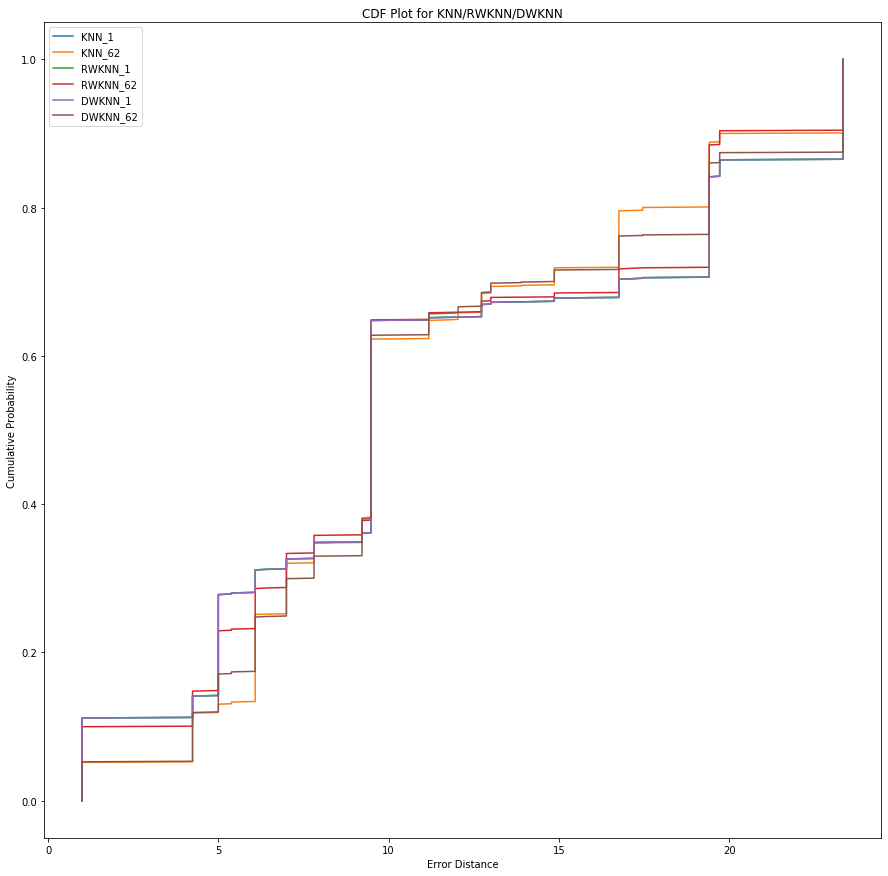

<Figure size 432x288 with 0 Axes>

In [51]:
fig= plt.figure(figsize=(15,15))
errorCDFPlot = ('E'+str(exp)+'_errorCDFPlot_T'+str(trial)+'.png')
knn_kcomp1_error = np.sort(KNNcomp1_errorSeries)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

knn_kcomp2_error = np.sort(KNNcomp2_errorSeries)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
plt.plot(knn_kcomp2_error,cdf, label = "KNN_62")

rwknn_kcomp1_error = np.sort(RWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(rwknn_kcomp1_error,cdf, label = "RWKNN_1")

rwknn_kcomp2_error = np.sort(RWKNNcomp2_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp2_error),step=1)/(len(rwknn_kcomp2_error)-1)
plt.plot(rwknn_kcomp2_error,cdf, label = "RWKNN_62")

dwknn_kcomp1_error = np.sort(DWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

dwknn_kcomp2_error = np.sort(DWKNNcomp2_errorSeries)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_62")

plt.legend()
plt.title('CDF Plot for KNN/RWKNN/DWKNN')
plt.xlabel('Error Distance')
plt.ylabel('Cumulative Probability')
plt.show()
plt.savefig(errorCDFPlot)

Median Error:
KNNcomp1      9.486833
KNNcomp2      9.486833
RWKNNcomp1    9.486833
RWKNNcomp2    9.486833
DWKNNcomp1    9.486833
DWKNNcomp2    9.486833
dtype: float64

0.75 Quantile Error:
KNNcomp1      19.416488
KNNcomp2      16.763055
RWKNNcomp1    19.416488
RWKNNcomp2    19.416488
DWKNNcomp1    19.416488
DWKNNcomp2    19.416488
Name: 0.75, dtype: float64

Max Error:
KNNcomp1      23.345235
KNNcomp2      23.345235
RWKNNcomp1    23.345235
RWKNNcomp2    23.345235
DWKNNcomp1    23.345235
DWKNNcomp2    23.345235
dtype: float64

Std Error:
KNNcomp1      7.244055
KNNcomp2      6.262052
RWKNNcomp1    7.244055
RWKNNcomp2    6.883297
DWKNNcomp1    7.244055
DWKNNcomp2    7.244055
dtype: float64


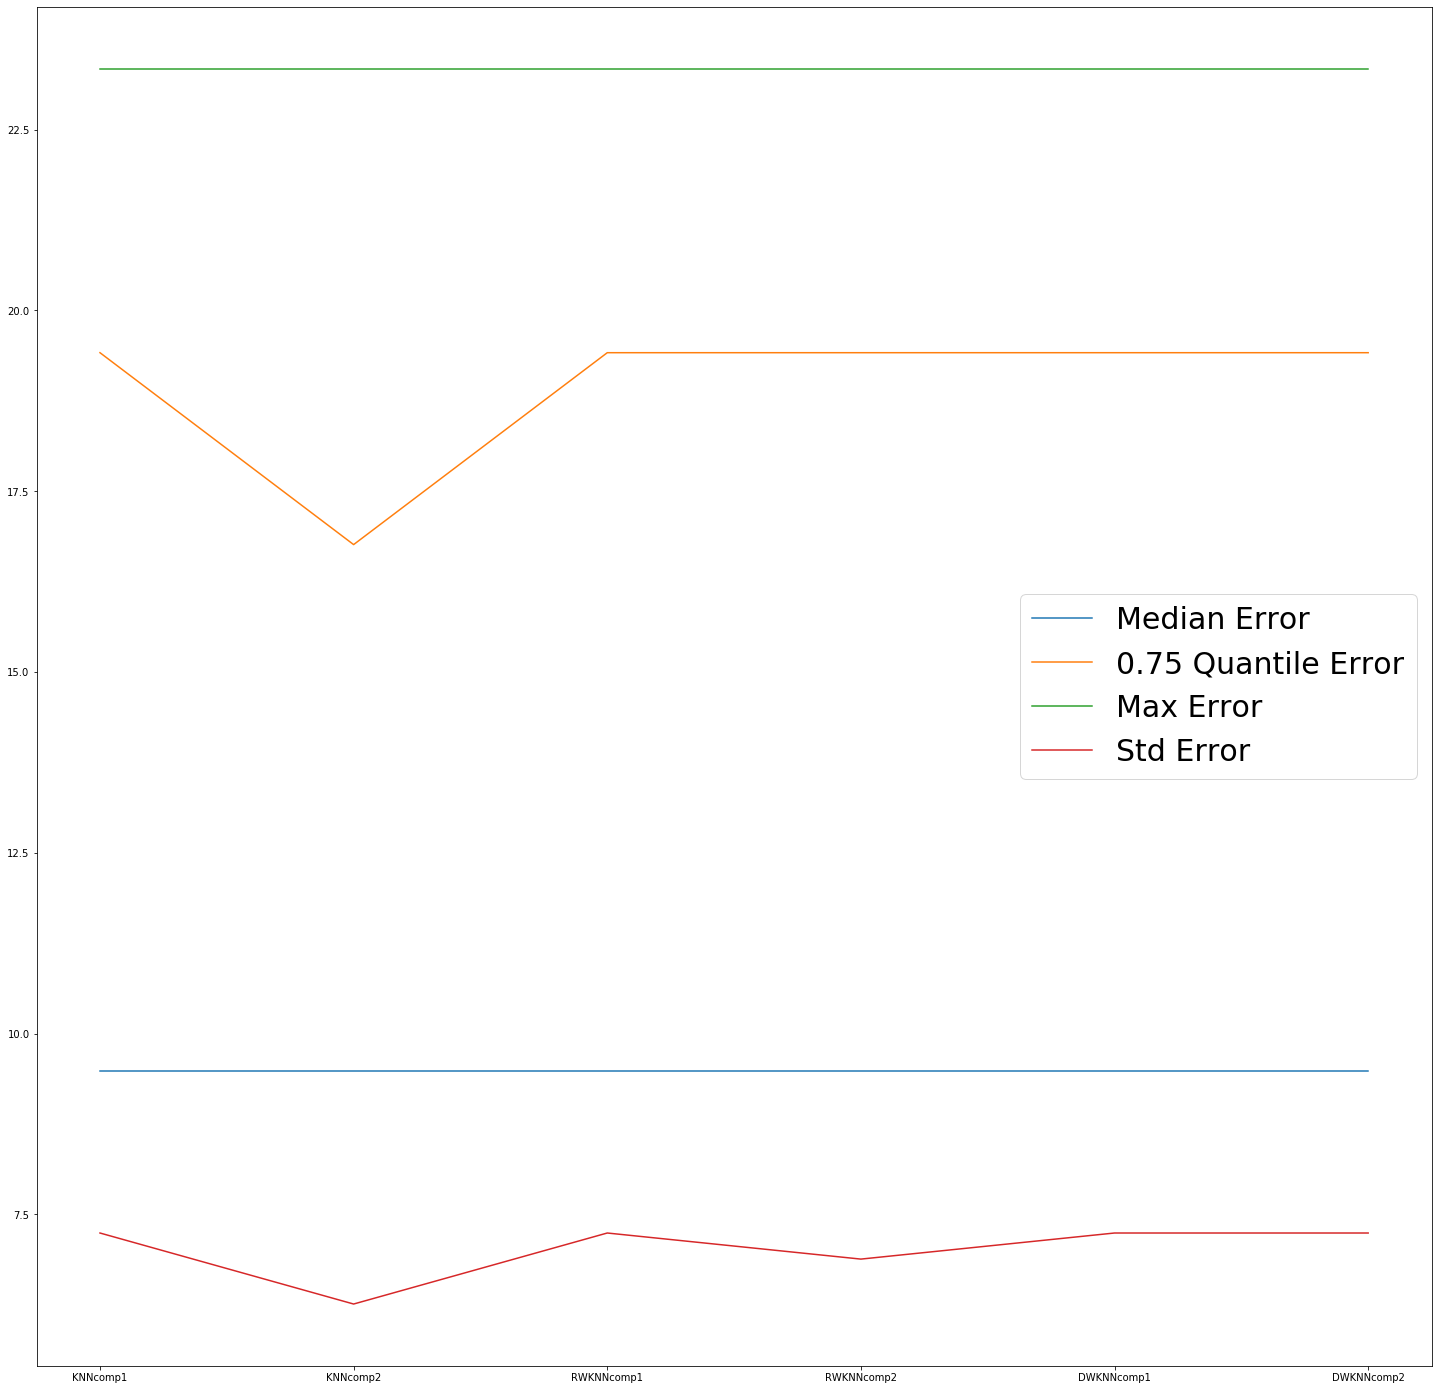

In [52]:
plt.figure(figsize = (25,25))
errorDf = errorDataframe


errorLine = ('E'+str(exp)+'_errorLine_T'+str(trial)+'.png')
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")

print("\n0.75 Quantile Error:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")
print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

print("\nStd Error:")
print(errorDf.std())
plt.plot(errorDf.std(), label = "Std Error")

plt.legend(loc = 'best', fontsize = 30)
plt.savefig(errorLine)

In [53]:
# Create Error File
kvalList = [1, 62]
writeErrSumm = True
fileNameErrSumm = ('E'+str(exp)+'_ErrSummary_T'+str(trial)+'.csv')
meanErrArr = []
medianErrArr = []
quantErrArr = []
maxErrArr = []
stdDevArr = []
for series in errorDf:
    meanErrArr.append(errorDf[series].mean())
    medianErrArr.append(errorDf[series].median())
    quantErrArr.append(errorDf[series].quantile(0.75))
    maxErrArr.append(errorDf[series].max())
    stdDevArr.append(errorDf[series].std())
    
errorSummary = pd.DataFrame(index=range(0,len(errorDf.columns)))
errorSummary.insert(loc=0, column="Mean Error", value=meanErrArr)
errorSummary.insert(loc=1, column="Median Error", value=medianErrArr)
errorSummary.insert(loc=2, column="0.75 Quantile Error", value=quantErrArr)
errorSummary.insert(loc=3, column="Max Error", value=maxErrArr)
errorSummary.insert(loc=4, column="Std Error", value=stdDevArr)
algoType = ["knn_k"+str(kvalList[0]), "knn_k"+str(kvalList[1]), "rwknn_k"+str(kvalList[0]), "rwknn_k"+str(kvalList[1]),
                "dwknn_k"+str(kvalList[0]), "dwknn_k"+str(kvalList[1])]

errorSummary.insert(loc=0, column="Algorithm", value = algoType)
print(errorSummary)


if (writeErrSumm == True):
    errorSummary.to_csv(fileNameErrSumm, index=False)
    print("File "+fileNameErrSumm+" has been written.")
# print(medianErrArr)

   Algorithm  Mean Error  Median Error  0.75 Quantile Error  Max Error  \
0     knn_k1   11.336680      9.486833            19.416488  23.345235   
1    knn_k62   11.290939      9.486833            16.763055  23.345235   
2   rwknn_k1   11.336680      9.486833            19.416488  23.345235   
3  rwknn_k62   11.193869      9.486833            19.416488  23.345235   
4   dwknn_k1   11.336680      9.486833            19.416488  23.345235   
5  dwknn_k62   11.336680      9.486833            19.416488  23.345235   

   Std Error  
0   7.244055  
1   6.262052  
2   7.244055  
3   6.883297  
4   7.244055  
5   7.244055  
File E3_ErrSummary_T1A.csv has been written.


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

temp = errorSummary['Algorithm']
errorSummary = errorSummary.reset_index()
errorSummary = errorSummary.drop(columns=['Algorithm'])
errorSummary.index = temp
errorSummary = errorSummary.drop(columns=['index'])
errorSummary


,Mean Error,Median Error,0.75 Quantile Error,Max Error,Std Error
Algorithm,,,,,
knn_k1,11.336680,9.486833,19.416488,23.345235,7.244055
knn_k62,11.290939,9.486833,16.763055,23.345235,6.262052
rwknn_k1,11.336680,9.486833,19.416488,23.345235,7.244055
rwknn_k62,11.193869,9.486833,19.416488,23.345235,6.883297
dwknn_k1,11.336680,9.486833,19.416488,23.345235,7.244055
dwknn_k62,11.336680,9.486833,19.416488,23.345235,7.244055


<Figure size 432x288 with 0 Axes>

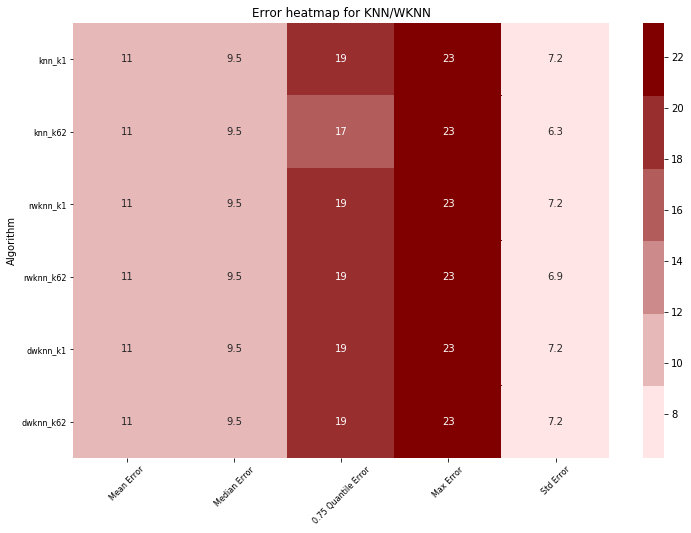

In [55]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
figName = ('E'+str(exp)+'_errorHeatMap_T'+str(trial)+'.png')
fig = plt.figure(facecolor='w', edgecolor='k')
fig =plt.figure(figsize=(12,8))
ax = plt.axes()
g = sns.heatmap(errorSummary, annot=True, cmap =sns.light_palette('maroon'))
sns.heatmap(errorSummary, mask= errorSummary > 5, annot=True, cmap=sns.light_palette('green'), cbar=False,
                ax = ax)
ax.set_title('Error heatmap for KNN/WKNN')
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 8)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
plt.savefig(figName)